In [3]:
import mrcfile
import os
import numpy
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
from tqdm import tqdm
import pickle
from sklearn.decomposition import PCA


### Construct dataset

In [4]:
def get_files_of_type_from_path(fpath, fext):
    '''
    Gets a list of all paths with a particular extension (fext) given a path (fpath)
    '''
    data_file_paths = []
    for file in os.listdir(fpath):
        if file.endswith(fext):
            data_file_paths.append(os.path.join(fpath, file))
    return data_file_paths

def get_all_imgs_from_mrcs(fname):
    '''
    Returns a list of 2D numpy arrays extracted from a given mrcs file (fname)
    '''
    if os.path.splitext(fname)[1]!='.mrcs':
        raise ValueError('File extension of {} is not .mrcs'.format(fname))
    
    with mrcfile.open(fname) as mrc:
        img_stack = mrc.data
        
    imgs = []
    if len(img_stack.shape)==3:
        for i in range(img_stack.shape[0]):
            imgs.append(img_stack[i,:,:])
    elif len(img_stack.shape)==2:
        imgs.append(img_stack)   

    return imgs

def get_all_imgs_from_paths(flist):
    '''
    Given a list of paths to .mrcs files (flist), produces a list of numpy arrays of images
    Note that this is creating an in-memory list, so don't use it with a large list of images
    '''
    all_imgs = []
    
    for fname in flist:
        imgs = get_all_imgs_from_mrcs(fname)
        all_imgs.extend(imgs)
    
    return all_imgs

def create_dataset_from_mrcs(classes, paths_in, paths_out, fext='.mrcs'):
    '''
    Given class classes (classes),
    a list of paths to folders containing .mrcs files (paths_in)
    and a list of paths to folders where .pkl files are to be stored (paths_out)
    This reads .mrcs files and writes one by one  
    '''
    
    for i, cl in enumerate(classes):
        # Create output path and img counter
        img_cntr = 0
        if not os.path.exists(paths_out[i]):
            os.makedirs(paths_out[i])
        
        # Get paths to .mrcs files to be processed
        in_paths = get_files_of_type_from_path(paths_in[i], fext)
        
        # Loop
        for fpath in tqdm(in_paths):
            # Get list of images
            imgs = get_all_imgs_from_mrcs(fpath)
            
            # Write images to files
            for img in imgs:
                np.save(os.path.join(paths_out[i], cl+'_'+str(img_cntr)+'.npy'), img)
                img_cntr += 1
                
def load_paths_into_array(paths):
    '''
    Given a list of paths (paths) of .pkl files of numpy arrays,
    return a list of numpy arrays
    '''
    arrs = []
    for p in paths:
        arrs.append(np.load(p))
    return arrs


In [5]:
# Data path
data_path = './data/Extract/'

# Paths of good/bad .mrcs files
good_path_in = os.path.join(data_path, 'job028/micrographs')
bad_path_in = os.path.join(data_path, 'job031/micrographs')

# Paths to store good/bad .pkl files
good_path_out = os.path.join(data_path, 'dataset0/good')
bad_path_out = os.path.join(data_path, 'dataset0/bad')


data_file_ext = '_lowpass.mrcs'

create_dataset_from_mrcs(   ['good', 'bad'],
                            [good_path_in, bad_path_in],
                            [good_path_out, bad_path_out],
                            fext=data_file_ext
                            )

100%|██████████| 671/671 [00:00<00:00, 1600.00it/s]


### Look at mean and std dev of classes

In [6]:
# Make dict of paths
data_paths = {'good':get_files_of_type_from_path(good_path_out, '.npy'),  
              'bad':get_files_of_type_from_path(bad_path_out, '.npy')}

# Load 
data = {'good': load_paths_into_array(data_paths['good']),
        'bad': load_paths_into_array(data_paths['bad'])}

# Stack 
arr_good = np.stack(data['good'],axis=0)
arr_bad =  np.stack(data['bad'],axis=0)

# Get average
arr_good_mean = np.mean(arr_good, axis=0)
arr_bad_mean = np.mean(arr_bad, axis=0)

# Get standard deviation
arr_good_std = np.std(arr_good, axis=0)
arr_bad_std = np.std(arr_bad, axis=0)

In [7]:
arr_stat_imgs = [arr_good_mean, arr_good_std, arr_bad_mean, arr_bad_std]
arr_stat_imgs_stack = np.stack(arr_stat_imgs, axis=0)
clim = [np.amin(arr_stat_imgs), np.amax(arr_stat_imgs)]

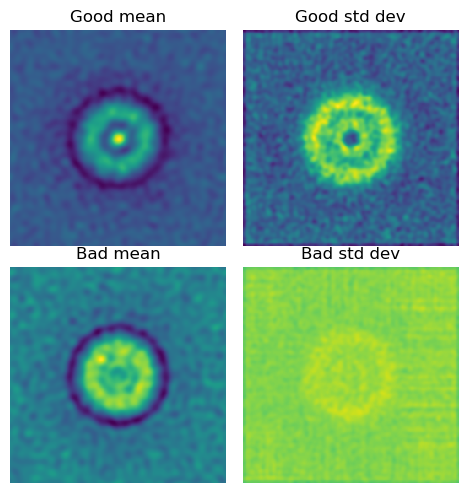

In [8]:
f, axarr = plt.subplots(2,2, figsize=[6,6], dpi= 100, gridspec_kw = {'wspace':0.0, 'hspace':0.1})
titles = ['Good mean', 'Good std dev', 'Bad mean', 'Bad std dev']
for i, ax in enumerate(f.get_axes()):
    ax.imshow(arr_stat_imgs[i])
    ax.axis('off')
    ax.set_title(titles[i])
for im in plt.gca().get_images():
    im.set_clim(clim)

### Do PCA

In [9]:
# Use all data
arr_all =  np.stack(data['good']+data['bad'],axis=0)

# Get average
arr_all_mean = np.mean(arr_all, axis=0)

# Get standard deviation
arr_all_std = np.std(arr_all, axis=0)

# Normalise
arr_all_norm = (arr_all-arr_all_mean)/np.sqrt(arr_all_std)

In [10]:
# Fit PCA
n_components = 9
arr_pca = PCA(n_components=n_components, svd_solver='randomized', whiten='True')
arr_all_flat = arr_all_norm.reshape(arr_all_norm.shape[0], arr_all_norm.shape[1]*arr_all_norm.shape[2])
arr_pca.fit(arr_all_flat)

PCA(n_components=9, svd_solver='randomized', whiten='True')

In [11]:
# Compute projection onto each category
def proj_onto_components(vectors, pca_comps, use_abs_sq=False):
    '''
    vectors should be a 2D numpy array of size [P, M]
    pca_comps should be a 2D numpy array of size [N, M]
    returns [N, P] array
    '''
    m = np.matmul(pca_comps, vectors.T)
    if use_abs_sq:
        m = np.square(m)
    return m

def avg_proj_onto_components(vectors, pca_comps, use_abs_sq=False):
    '''
    vectors should be a 2D numpy array of size [P, M]
    pca_comps should be a 2D numpy array of size [N, M]
    '''
    m = proj_onto_components(vectors, pca_comps, use_abs_sq=use_abs_sq)
    return np.mean(m, axis=1), np.std(m, axis=1)

def flatten_stack(arr):
    return arr.reshape(arr.shape[0], -1)

In [12]:
avg_good, std_good = avg_proj_onto_components(flatten_stack(np.stack(data['good'], axis=0)), arr_pca.components_, use_abs_sq=True)
avg_bad, std_bad = avg_proj_onto_components(flatten_stack(np.stack(data['bad'], axis=0)), arr_pca.components_, use_abs_sq=True)

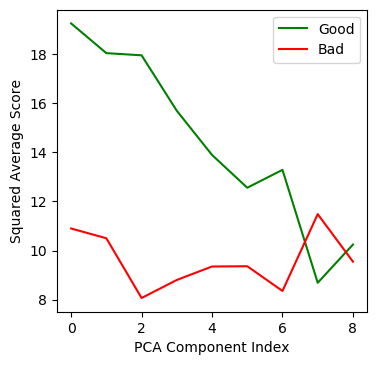

In [13]:
# Plot average projection onto components for each class
fig = plt.figure(figsize=(4,4), dpi=100)
plt.plot(list(range(n_components)), avg_good, 'g', label='Good')
plt.plot(list(range(n_components)), avg_bad, 'r', label='Bad')
plt.xlabel('PCA Component Index')
plt.ylabel('Squared Average Score')
plt.legend()

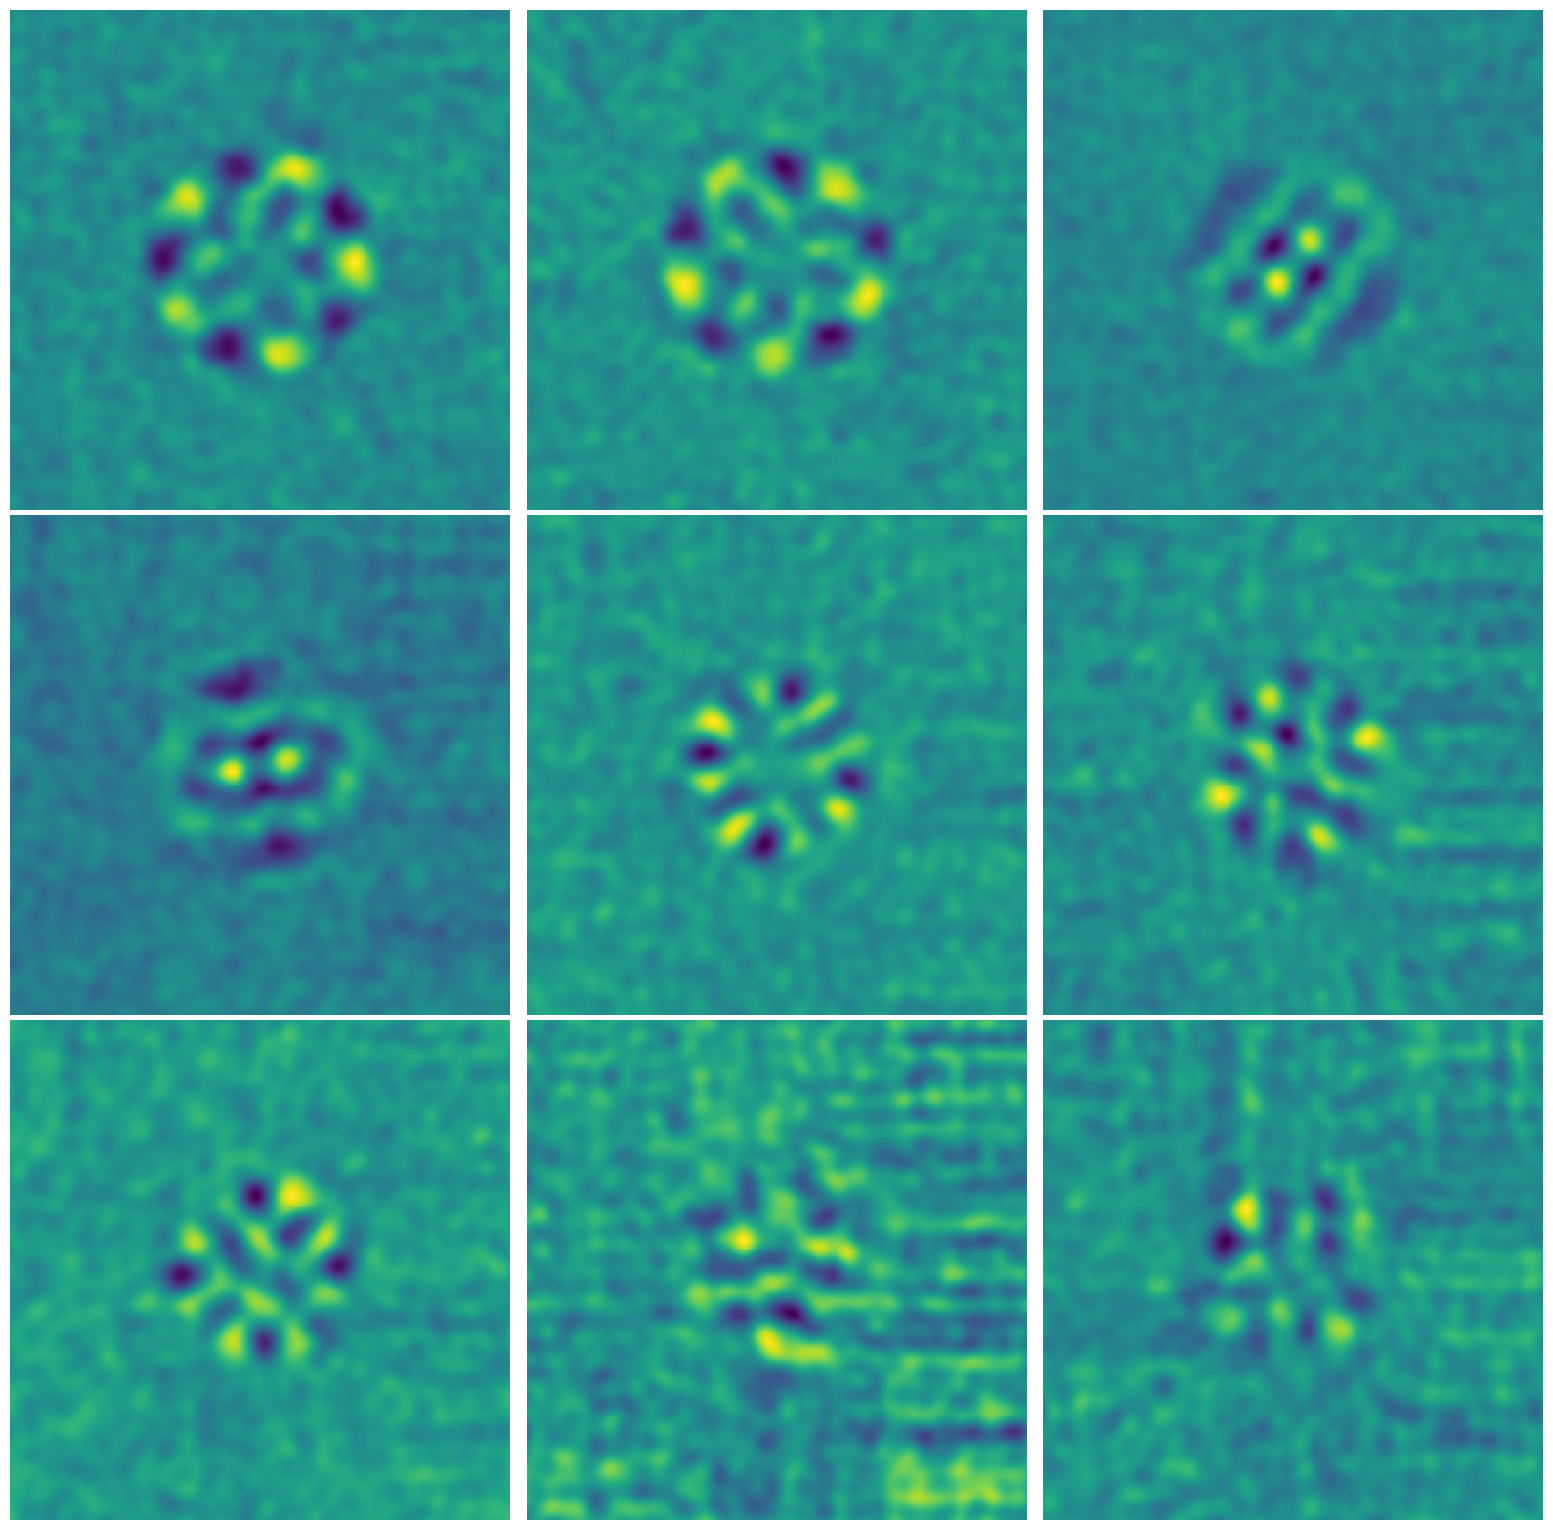

In [14]:
# Plot components
fig, axs = plt.subplots(3, 3, figsize=(20, 20), dpi= 100, gridspec_kw = {'wspace':0.0, 'hspace':0.01})

for i, ax in enumerate(fig.get_axes()):
    arr = arr_pca.components_[i,:]
    ax.imshow(arr.reshape(int(np.sqrt(arr.shape[0])), int(np.sqrt(arr.shape[0]))) )
    ax.axis('off')

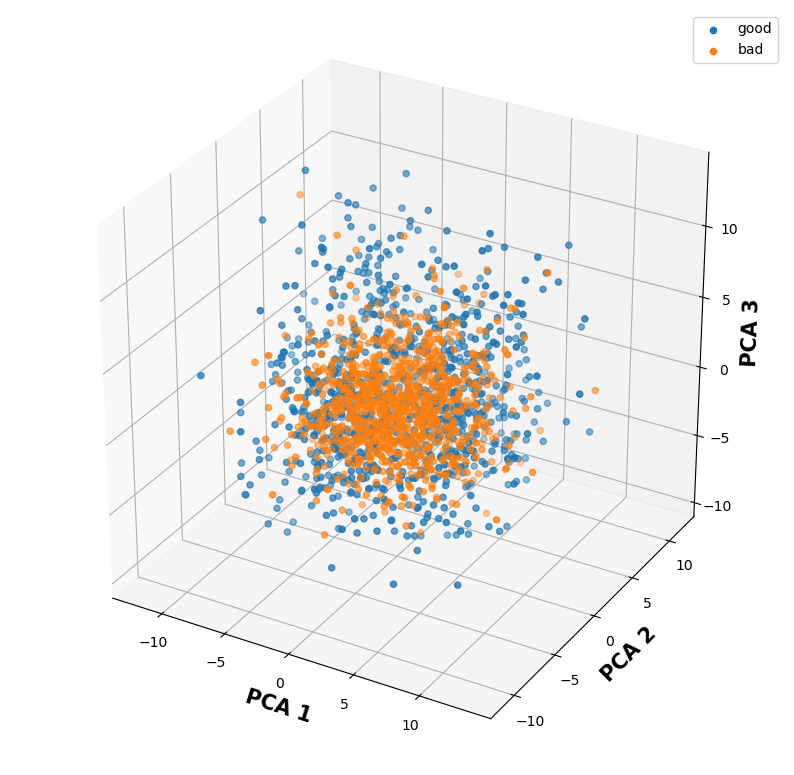

In [17]:
# 3D View of first 3 components
good_proj = proj_onto_components(flatten_stack(np.stack(data['good'], axis=0)), arr_pca.components_, use_abs_sq=False)
bad_proj = proj_onto_components(flatten_stack(np.stack(data['bad'], axis=0)), arr_pca.components_, use_abs_sq=False)

from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=[10,10], dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(good_proj[0,:], good_proj[1,:], good_proj[2,:], marker='o', label='good')
ax.scatter(bad_proj[0,:], bad_proj[1,:], bad_proj[2,:], marker='o', label='bad')
ax.set_xlabel('PCA 1', fontsize=15, fontweight='bold')
ax.set_ylabel('PCA 2', fontsize=15, fontweight='bold')
ax.set_zlabel('PCA 3', fontsize=15, fontweight='bold')
plt.legend()
plt.show()